In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from src.data import load_scTFseq
from src.ridge_permutation import ridge_permutation_testing
from src.eval_networks import mm10_stem_cells_chip_atlas, load_regulons
from src.eval_utils import calculate_auprc
from src.plot_utils import plot_precision_recall_curve, plot_expression_curve
from src.probabilistic_model import ResponseModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from adjustText import adjust_text
import pandas as pd
import networkx as nx
import scanpy as sc
from tqdm import tqdm
import random
import celloracle as co

sns.set_style('whitegrid')
sns.set_style('white')
# sns.set_context('paper', font_scale = 1.2)
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
adata = load_scTFseq()

#### Ridge baseline

In [ ]:
true_coefs_df, perm_coefs, ridge_perm_df = ridge_permutation_testing(adata, n_perm=100)

Performing permutation testing ...


 12%|█████████▏                                                                   | 12/100 [00:11<01:23,  1.05it/s]

Text(0.5, 1.0, 'TF: Esr2, TG: Net1, p-value: 0.0, # permutations: 1000')

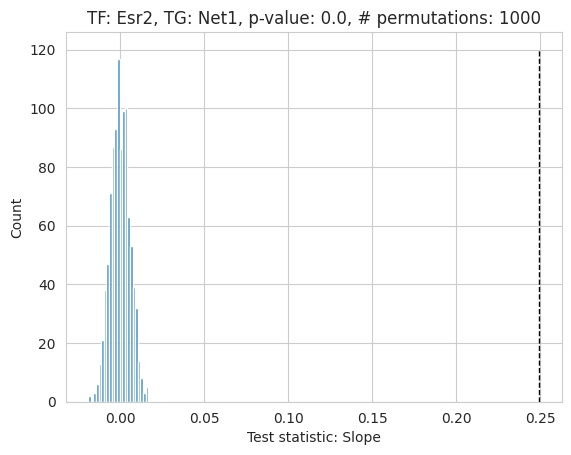

In [360]:
tf = 'Esr2'; tg = 'Net1'
# tf = 'Pparg'; tg = 'Serpine1'
gene_idx = np.where(adata.var['Symbol'] == tg)[0][0]
j = adata.uns['conditions_dict'][tf]
sns.histplot(perm_coefs[:, i, j])
plt.vlines(true_coefs[i, j], 0, 120, linestyles='dashed', colors='black', linewidth=1);
plt.xlabel('Test statistic: Slope')
plt.title(f'TF: {tf}, TG: {tg}, p-value: {ridge_perm_df[tf][tg]}, # permutations: 1000')

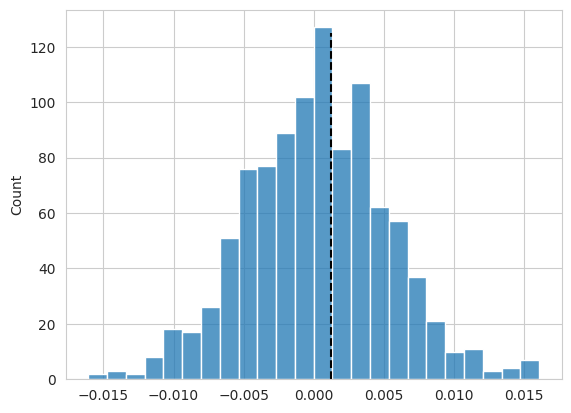

In [363]:
# tf = 'Esr2'; tg = 'Net1'
tf = 'Pparg'; tg = 'Serpine1'
gene_idx = np.where(adata.var['Symbol'] == tg)[0][0]
j = adata.uns['conditions_dict'][tf]
sns.histplot(perm_coefs[:, i, j])
plt.vlines(true_coefs[i, j], 0, 125, linestyles='dashed', colors='black');

#### Response model

In [ ]:
##### Setup params
adata.obs['pert_id'] = adata.obs['TF']
ResponseModel.setup_anndata(adata)

# Define model
model = ResponseModel(
    adata,
    # likelihood_fn='normal',
    likelihood_fn='zinb',
    n_latent=256,
    null_model=False
)

In [ ]:
model.train(max_epochs=200,
            batch_size=256,
            check_val_every_n_epoch=1, accelerator='cuda', devices=[0])

In [ ]:
out = model.infer_expression(adata, library_size=1e4)
adata.layers['mean'] = np.clip(out['log_norm_mean'], 0, a_max=None)
adata.layers['var'] = np.clip(out['log_norm_var'], 0, a_max=None)
out.keys()

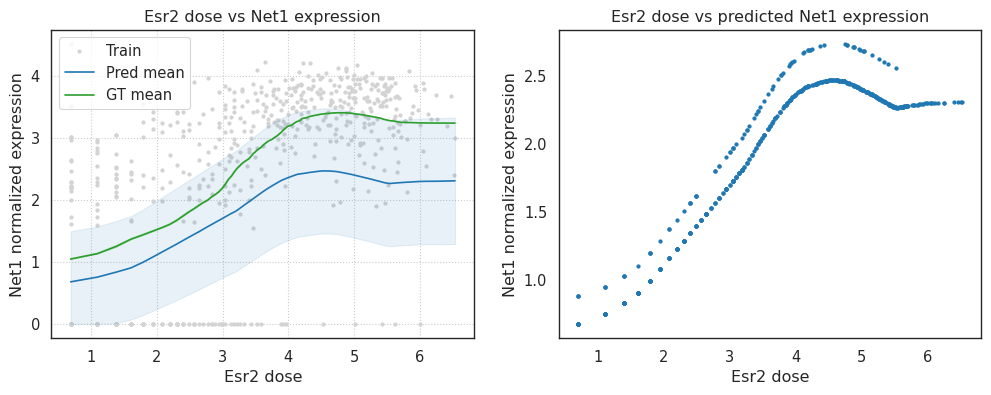

In [26]:
TF = 'Esr2'
TG = 'Net1'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
plt.figure(figsize=(12, 4))
plot_expression_curve(TF, gene_idx, adata, raw_counts=model.likelihood_fn == 'zinb')

#### Null model

In [ ]:
# Define model
null_model = ResponseModel(
    adata,
    # likelihood_fn='normal',
    likelihood_fn='zinb',
    n_latent=256,
    null_model=True
)

In [ ]:
null_model.train(max_epochs=200,
            batch_size=256,
            check_val_every_n_epoch=1, accelerator='cuda', devices=[0])

In [ ]:
null_out = null_model.infer_expression(adata, library_size=1e4)
adata.layers['null_mean'] = np.clip(null_out['log_norm_mean'], 0, a_max=None)
adata.layers['null_var'] = np.clip(null_out['log_norm_var'], 0, a_max=None)
null_out.keys()

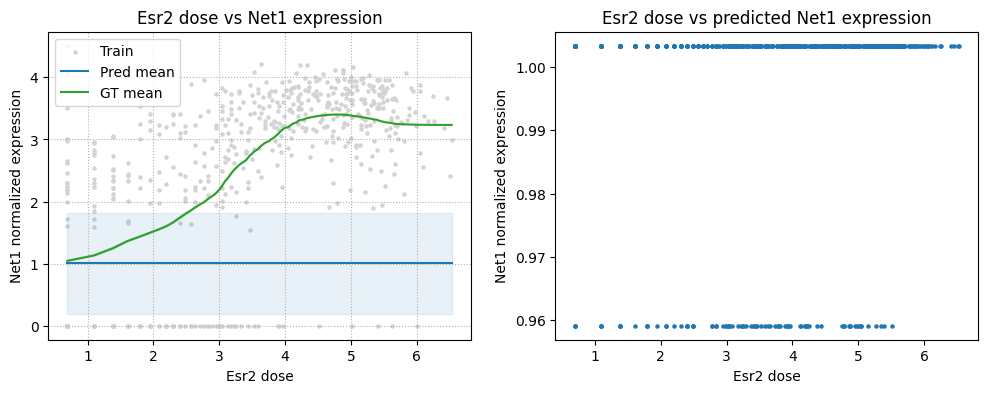

In [96]:
TF = 'Esr2'
TG = 'Net1'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
plt.figure(figsize=(12, 4))
plot_expression_curve(TF, gene_idx, adata,
                      raw_counts=model.likelihood_fn == 'zinb',
                      mean_layer_key='null_mean', var_layer_key='null_var')

#### Log-likelihood ratio

In [ ]:
adata.layers['log_likelihood_ratio'] = -2*(null_out['log_likelihood'] - out['log_likelihood'])

890.3323


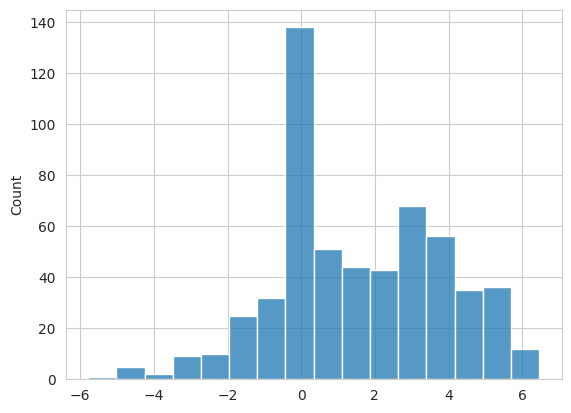

In [612]:
TF = 'Esr2' # 'Pparg'
TG = 'Net1' # 'Fabp4'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
m = adata.obs['TF'] == TF
log_likelihood_ratios = adata[m, gene_idx].layers['log_likelihood_ratio'].ravel()
sns.histplot(log_likelihood_ratios)
print(log_likelihood_ratios.sum())

7.6049376


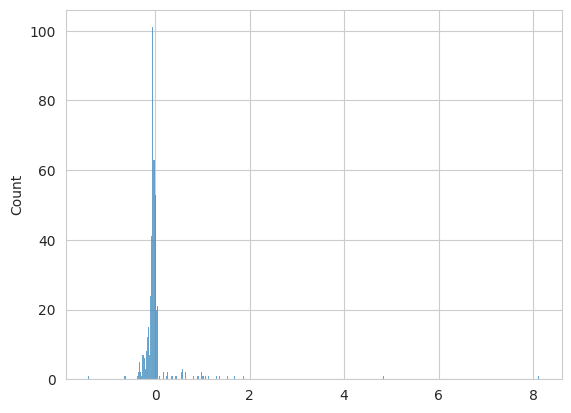

In [613]:
TF = 'Pparg'
TG = 'Fabp4'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
m = adata.obs['TF'] == TF
log_likelihood_ratios = adata[m, gene_idx].layers['log_likelihood_ratio'].ravel()
sns.histplot(log_likelihood_ratios)
print(log_likelihood_ratios.sum())

In [ ]:
n_latent = 256
unique_TFs = adata.obs['TF'].unique()
unique_TGs = adata.var['Symbol']
p_values = np.zeros((len(unique_TFs), len(unique_TGs)))
ll_ratios = np.zeros((len(unique_TFs), len(unique_TGs)))
for i, tf in enumerate(tqdm(unique_TFs)):
    for j, tg in enumerate(unique_TGs):
        gene_idx = np.where(adata.var['Symbol'] == tg)[0][0]
        m = adata.obs['TF'] == tf
        log_likelihood_ratios = adata[m, gene_idx].layers['log_likelihood_ratio'].ravel()
        log_likelihood_ratio = log_likelihood_ratios.sum()
        ll_ratios[i, j] = log_likelihood_ratio
        p_values[i, j] = chi2.sf(log_likelihood_ratio, n_latent)
p_df = pd.DataFrame(p_values.T, index=unique_TGs, columns=unique_TFs)
ll_df = pd.DataFrame(ll_ratios.T, index=unique_TGs, columns=unique_TFs)

#### Evaluate

In [5]:
# Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN_unique_df = base_GRN.iloc[:, 1:]
base_GRN_unique_df = base_GRN_unique_df.groupby('gene_short_name').max()
base_GRN_unique_df

,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,Al592170.2,Al662824.5,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
gene_short_name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
0610007C21Rik,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
0610007L01Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610007P08Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0610007P22Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
snoU6-77,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
snoU85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
snoU89,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Instantiate Oracle object
sc.pp.neighbors(adata)
sc.tl.draw_graph(adata)
oracle = co.Oracle()

In [7]:
# Instantiate Oracle object
adata.layers['raw_count'] = adata.layers['counts']
oracle.import_anndata_as_normalized_count(adata=adata,
                                   cluster_column_name="cell_type",
                                   embedding_name="X_draw_graph_fa")

... storing 'cell_type' as categorical
... storing 'perturbation_type' as categorical
... storing 'organism' as categorical
... storing 'reference_genome' as categorical
... storing 'genome_build' as categorical
... storing 'ENSEMBL_version' as categorical
... storing 'strand' as categorical


In [8]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

52


In [ ]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=1)

cell number is :46375
Auto-selected k is :1159


In [ ]:
oracle_links = oracle.get_links(cluster_name_for_GRN_unit="cell_type", alpha=10, verbose_level=10)

In [74]:
# Filter out genes and TF not present in the base graph
tgs = np.intersect1d(base_GRN_unique_df.index, adata.var['Symbol'].values)
tfs = np.intersect1d(base_GRN_unique_df.columns, adata.obs['TF'].unique())
ll_unprunned_df = ll_df.loc[tgs, tfs]
ridge_unprunned_df = true_coefs_df.loc[tgs, tfs]
ll_base_df = ll_unprunned_df * base_GRN_unique_df.loc[tgs, tfs]
ridge_base_df = ridge_unprunned_df * base_GRN_unique_df.loc[tgs, tfs]

pred_dfs = {'Ridge': true_coefs_df, 'LR-ZINB': ll_df}
pred_base_dfs = {'Ridge (unprunned)': ridge_unprunned_df,
                 'Ridge (base-pruned)': ridge_base_df,
                 'LR-ZINB (unprunned)': ll_unprunned_df,
                 'LR-ZINB (base-pruned)': ll_base_df}

In [37]:
# Mouse regulon network
mouse_regulons = load_regulons(min_refs=2)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]

# Chip-atlas derived network (mouse pluripotent stem cells)
mm10_stem_network = mm10_stem_cells_chip_atlas()
filtered_mm10_stem_network = mm10_stem_network[mm10_stem_network['source'].isin(adata.obs['TF'].unique()) & mm10_stem_network['target'].isin(adata.var['Symbol'])]
filtered_mm10_stem_network = filtered_mm10_stem_network[filtered_mm10_stem_network['cell_type'] == 'ES cells']
filtered_mm10_stem_network

2024-12-13 14:18:15,551 - INFO - Downloading data from `https://omnipathdb.org/queries/enzsub?format=json`
2024-12-13 14:18:15,672 - INFO - Downloading data from `https://omnipathdb.org/queries/interactions?format=json`
2024-12-13 14:18:15,751 - INFO - Downloading data from `https://omnipathdb.org/queries/complexes?format=json`
2024-12-13 14:18:15,831 - INFO - Downloading data from `https://omnipathdb.org/queries/annotations?format=json`
2024-12-13 14:18:15,913 - INFO - Downloading data from `https://omnipathdb.org/queries/intercell?format=json`
2024-12-13 14:18:16,056 - INFO - Downloading data from `https://omnipathdb.org/about?format=text`


,chr_1,start_1,end_1,exp_id,MACS2,chr_2,start_2,end_2,TG,overlap,TF,cell_type,TG_name,TF_name,source,target
144281,chr1,12691810,12692417,SRX13228088,1691,chr1,12692277,12861192,ENSMUSG00000016918,140,Sox2,ES cells,Sulf1,Sox2,Sox2,Sulf1
144282,chr1,12691822,12692303,SRX6032059,466,chr1,12692277,12861192,ENSMUSG00000016918,26,Sox2,ES cells,Sulf1,Sox2,Sox2,Sulf1
144289,chr1,12691843,12692437,SRX9858290,791,chr1,12692277,12861192,ENSMUSG00000016918,160,Ep300,ES cells,Sulf1,Ep300,Ep300,Sulf1
144303,chr1,12691857,12692417,SRX2437564,636,chr1,12692277,12861192,ENSMUSG00000016918,140,Ep300,ES cells,Sulf1,Ep300,Ep300,Sulf1
144327,chr1,12691880,12692316,SRX9486379,843,chr1,12692277,12861192,ENSMUSG00000016918,39,Sox2,ES cells,Sulf1,Sox2,Sox2,Sulf1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58118778,chrX,169320327,169320479,SRX143842,233,chrX,169250193,169320372,ENSMUSG00000031352,45,Ep300,ES cells,Hccs,Ep300,Ep300,Hccs
58118800,chrX,169320349,169320625,SRX16815349,144,chrX,169250193,169320372,ENSMUSG00000031352,23,Pou5f1,ES cells,Hccs,Pou5f1,Pou5f1,Hccs
58118802,chrX,169320349,169320750,SRX9372868,161,chrX,169250193,169320372,ENSMUSG00000031352,23,Ep300,ES cells,Hccs,Ep300,Ep300,Hccs
58118804,chrX,169320350,169320660,SRX16815350,196,chrX,169250193,169320372,ENSMUSG00000031352,22,Pou5f1,ES cells,Hccs,Pou5f1,Pou5f1,Hccs


<Axes: xlabel='MACS2', ylabel='Count'>

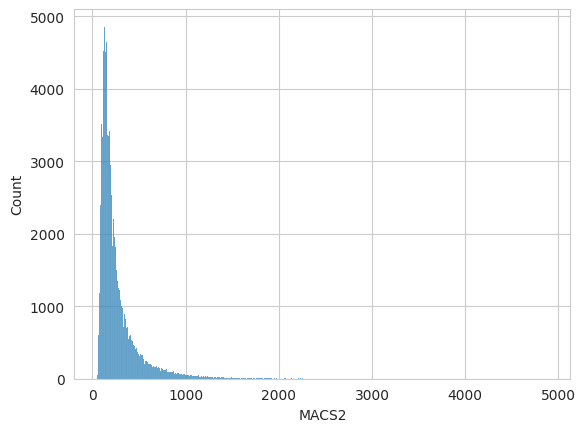

In [263]:
tf = 'Pou5f1'
sns.histplot(filtered_mm10_stem_network[filtered_mm10_stem_network['source'] == tf]['MACS2'])

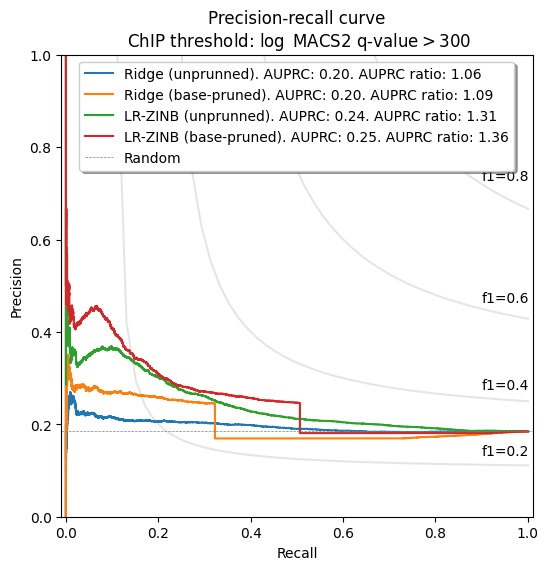

In [78]:
threshold = 300
filtered_mm10_stem_network_ = filtered_mm10_stem_network[filtered_mm10_stem_network['source'].isin(tfs) & filtered_mm10_stem_network['target'].isin(tgs)]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_[filtered_mm10_stem_network_['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_base_dfs,
                            filtered_mm10_stem_network_unique,
                            title=f'ChIP threshold: $\log$ MACS2 q-value$>{threshold}$')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  7.04it/s]


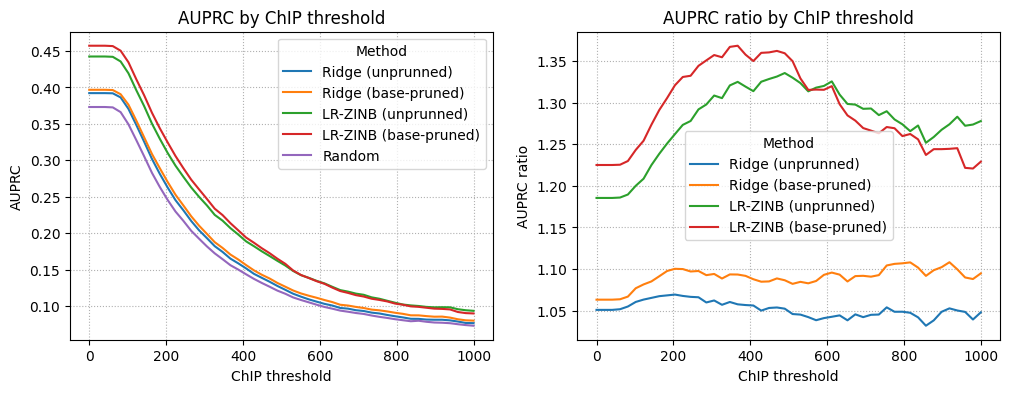

In [81]:
thresholds = np.linspace(0, 1000, 50)
results_df = pd.DataFrame(columns=['Method', 'AUPRC', 'AUPRC ratio', 'ChIP threshold'])
for threshold in tqdm(thresholds):
    filtered_mm10_stem_network_ = filtered_mm10_stem_network[filtered_mm10_stem_network['source'].isin(tfs) & filtered_mm10_stem_network['target'].isin(tgs)]
    filtered_mm10_stem_network_unique = filtered_mm10_stem_network_[filtered_mm10_stem_network_['MACS2'] > threshold]
    filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
    filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
    for k, v in pred_base_dfs.items():
        auprc, auprc_ratio = calculate_auprc(v, filtered_mm10_stem_network_unique)
        results_df.loc[len(results_df)] = [k, auprc, auprc_ratio, threshold]
    n_tfs = len(filtered_mm10_stem_network_unique['source'].unique())
    n_tgs = len(filtered_mm10_stem_network_unique['target'].unique())
    random_auprc = len(filtered_mm10_stem_network_unique) / (n_tfs * n_tgs)
    results_df.loc[len(results_df)] = ['Random', random_auprc, np.nan, threshold]
chip_results_df = results_df

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=chip_results_df, x='ChIP threshold', y='AUPRC', hue='Method')
plt.title('AUPRC by ChIP threshold')
plt.grid(linestyle='dotted')

plt.subplot(1, 2, 2)
sns.lineplot(data=chip_results_df[chip_results_df['Method'] != 'Random'], x='ChIP threshold', y='AUPRC ratio', hue='Method')
plt.title('AUPRC ratio by ChIP threshold')
plt.grid(linestyle='dotted')

plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.90it/s]


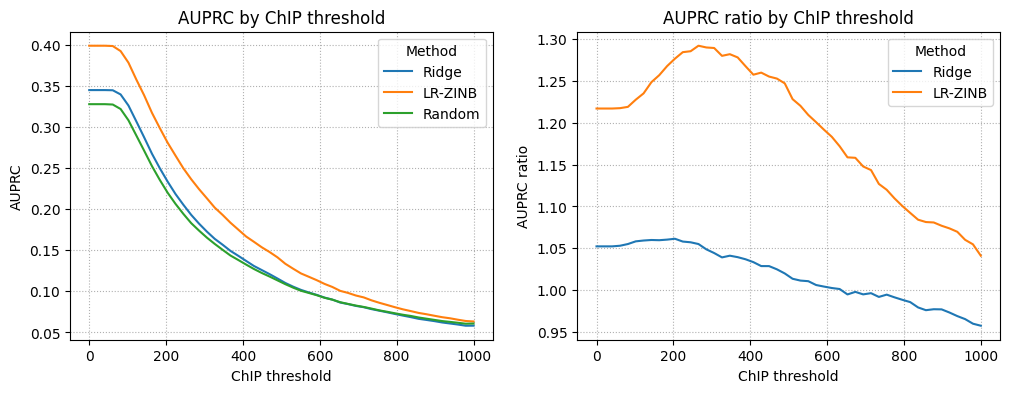

In [1034]:
thresholds = np.linspace(0, 1000, 50)
results_df = pd.DataFrame(columns=['Method', 'AUPRC', 'AUPRC ratio', 'ChIP threshold'])
for threshold in tqdm(thresholds):
    filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
    filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
    filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
    for k, v in pred_dfs.items():
        auprc, auprc_ratio = calculate_auprc(v, filtered_mm10_stem_network_unique)
        results_df.loc[len(results_df)] = [k, auprc, auprc_ratio, threshold]
    n_tfs = len(filtered_mm10_stem_network_unique['source'].unique())
    n_tgs = len(filtered_mm10_stem_network_unique['target'].unique())
    random_auprc = len(filtered_mm10_stem_network_unique) / (n_tfs * n_tgs)
    results_df.loc[len(results_df)] = ['Random', random_auprc, np.nan, threshold]
chip_results_df = results_df

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=chip_results_df, x='ChIP threshold', y='AUPRC', hue='Method')
plt.title('AUPRC by ChIP threshold')
plt.grid(linestyle='dotted')

plt.subplot(1, 2, 2)
sns.lineplot(data=chip_results_df[chip_results_df['Method'] != 'Random'], x='ChIP threshold', y='AUPRC ratio', hue='Method')
plt.title('AUPRC ratio by ChIP threshold')
plt.grid(linestyle='dotted')

plt.show()

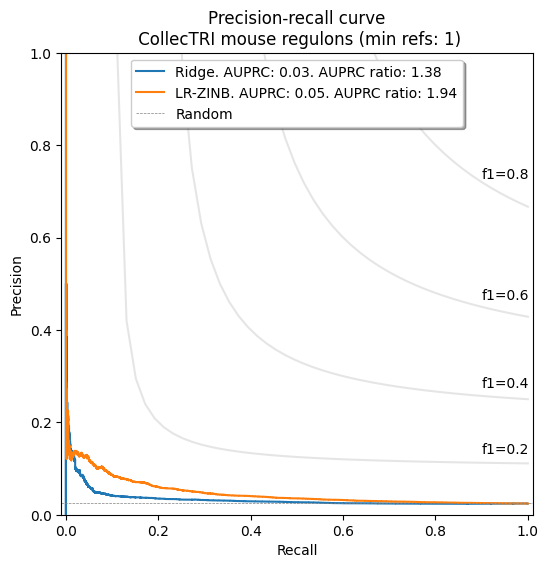

In [1033]:
min_refs=1
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')
plt.show()

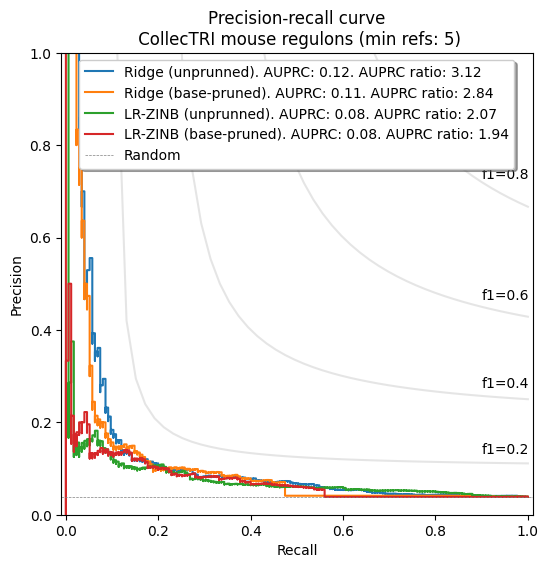

In [83]:
min_refs=5
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(tfs) & mouse_regulons['target'].isin(tgs)]
plot_precision_recall_curve(pred_base_dfs, filtered_mouse_regulons,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.94s/it]


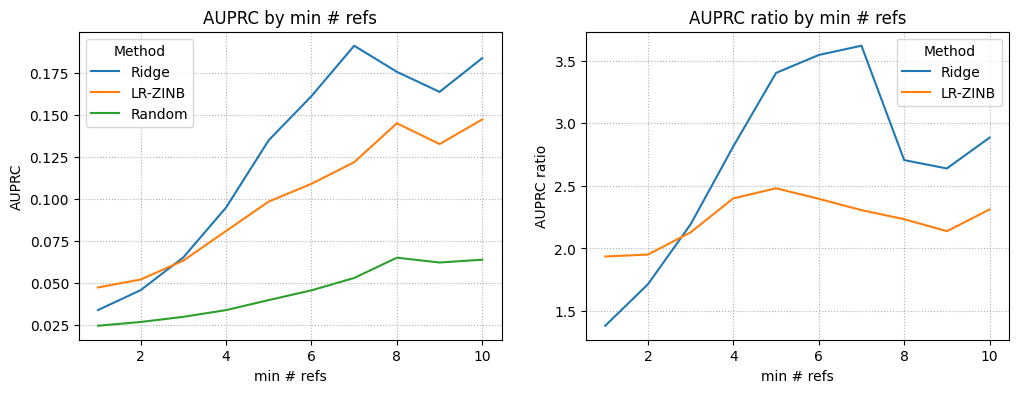

In [1035]:
refs = np.arange(10) + 1
results_df = pd.DataFrame(columns=['Method', 'AUPRC', 'AUPRC ratio', 'min # refs'])
for min_refs in tqdm(refs):
    mouse_regulons = load_regulons(min_refs=min_refs)
    filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
    for k, v in pred_dfs.items():
        auprc, auprc_ratio = calculate_auprc(v, filtered_mouse_regulons)
        results_df.loc[len(results_df)] = [k, auprc, auprc_ratio, min_refs]
    n_tfs = len(filtered_mouse_regulons['source'].unique())
    n_tgs = len(filtered_mouse_regulons['target'].unique())
    random_auprc = len(filtered_mouse_regulons) / (n_tfs * n_tgs)
    results_df.loc[len(results_df)] = ['Random', random_auprc, np.nan, min_refs]
collectri_results_df = results_df

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=collectri_results_df, x='min # refs', y='AUPRC', hue='Method')
plt.title('AUPRC by min # refs')
plt.grid(linestyle='dotted')

plt.subplot(1, 2, 2)
sns.lineplot(data=collectri_results_df[collectri_results_df['Method'] != 'Random'], x='min # refs', y='AUPRC ratio', hue='Method')
plt.title('AUPRC ratio by min # refs')
plt.grid(linestyle='dotted')

plt.show()

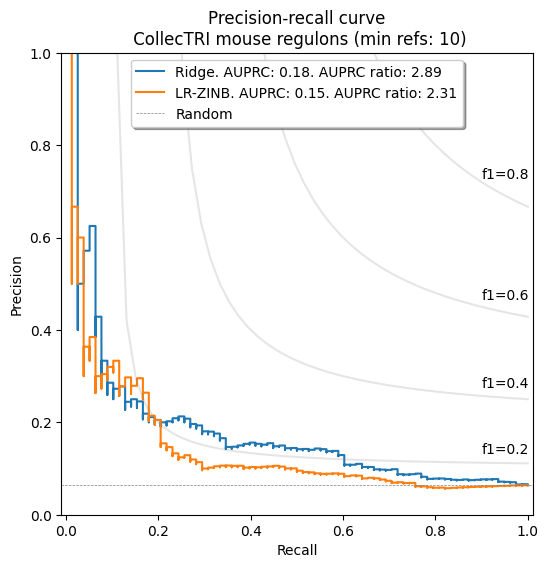

In [1038]:
min_refs=10
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')
plt.show()

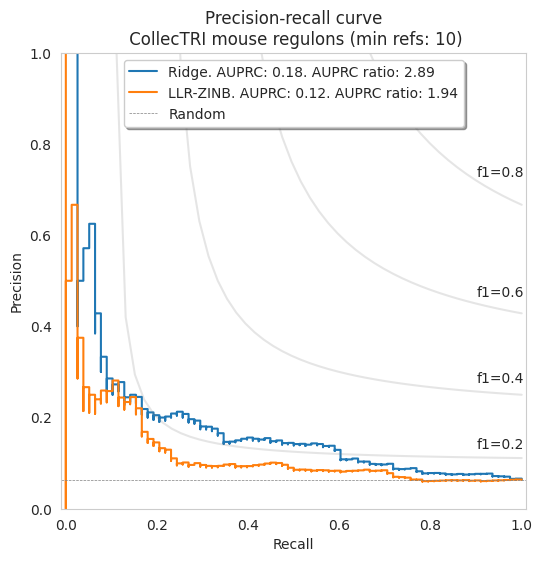

In [672]:
min_refs=10
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

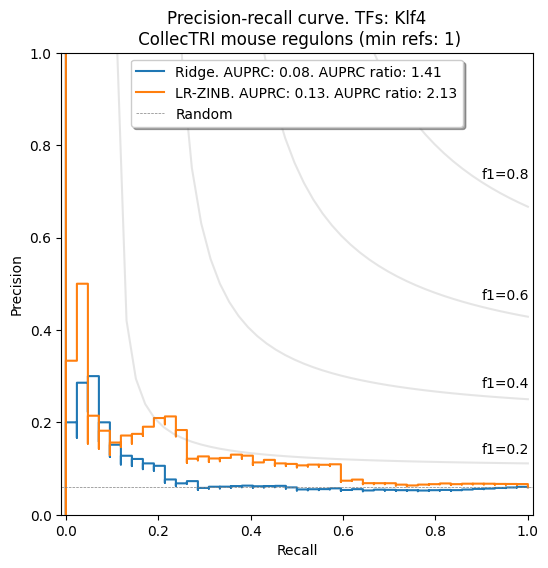

In [1039]:
tfs = ['Klf4']
# filtered_mouse_regulons_ = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
min_refs=1
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')
plt.show()

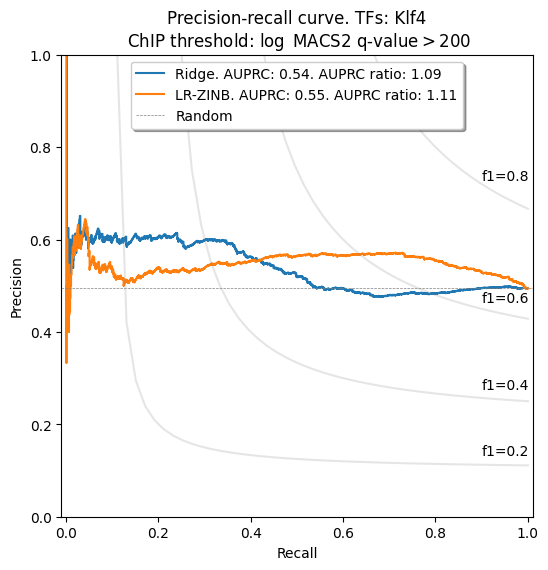

In [1040]:
tfs = ['Klf4']
threshold = 200
filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_dfs, filtered_mm10_stem_network_unique, tfs,
                            title=f'ChIP threshold: $\log$ MACS2 q-value$>{threshold}$')
plt.show()

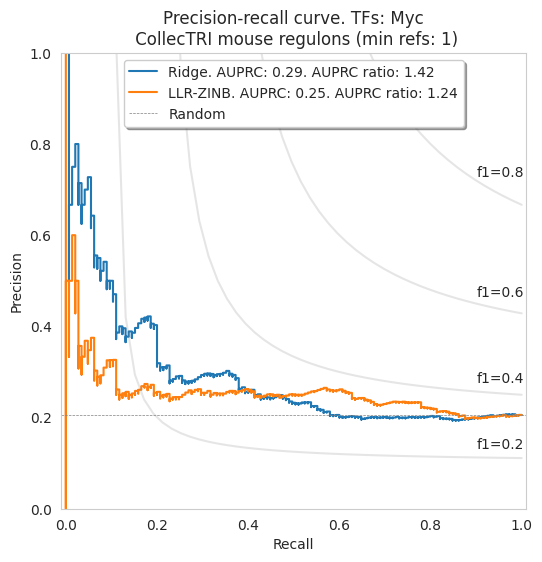

In [838]:
tfs = ['Myc']
# filtered_mouse_regulons_ = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
min_refs=1
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

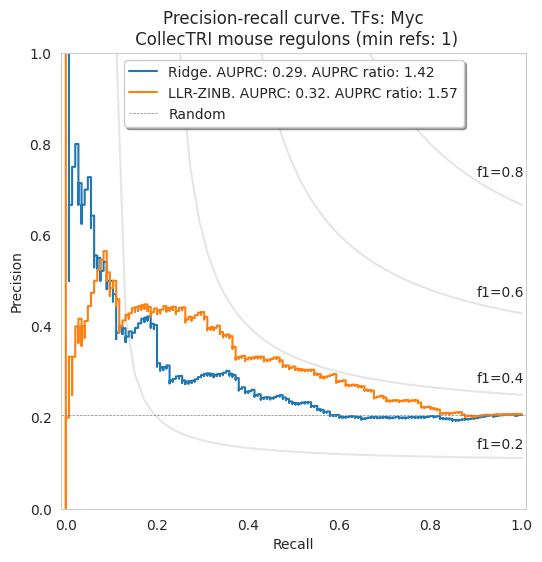

In [695]:
tfs = ['Myc']
# filtered_mouse_regulons_ = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
min_refs=1
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

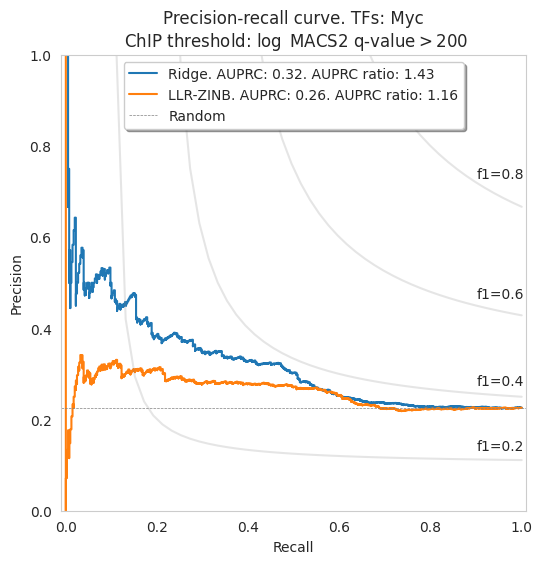

In [698]:
tfs = ['Myc']
threshold = 200
filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_dfs, filtered_mm10_stem_network_unique, tfs,
                            title=f'ChIP threshold: $\log$ MACS2 q-value$>{threshold}$')

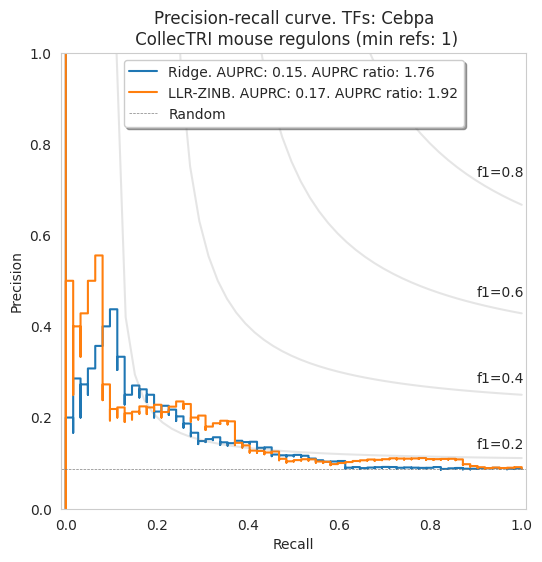

In [795]:
tfs = ['Cebpa']
# filtered_mouse_regulons_ = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
min_refs=1
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

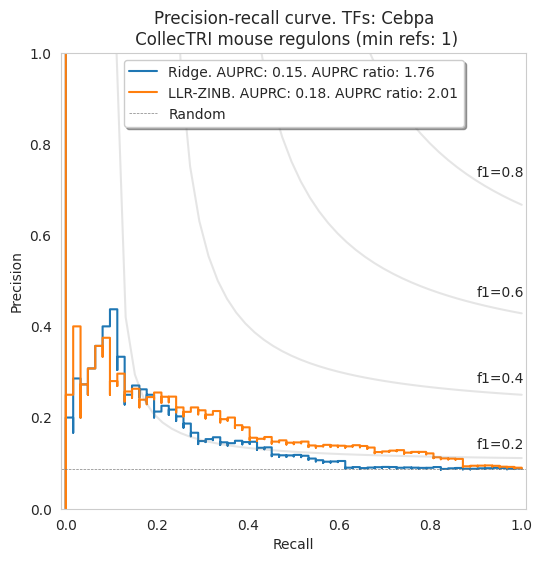

In [699]:
tfs = ['Cebpa']
# filtered_mouse_regulons_ = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
min_refs=1
mouse_regulons = load_regulons(min_refs=min_refs)
filtered_mouse_regulons = mouse_regulons[mouse_regulons['source'].isin(adata.obs['TF'].unique()) & mouse_regulons['target'].isin(adata.var['Symbol'])]
plot_precision_recall_curve(pred_dfs, filtered_mouse_regulons, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

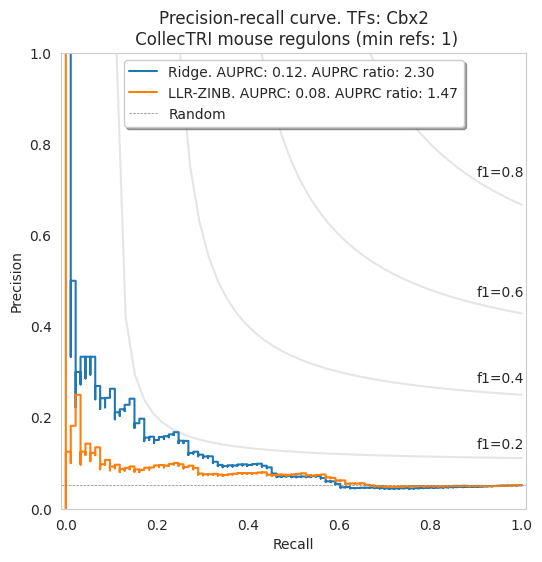

In [796]:
tfs = ['Cbx2']
threshold = 200
filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_dfs, filtered_mm10_stem_network_unique, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

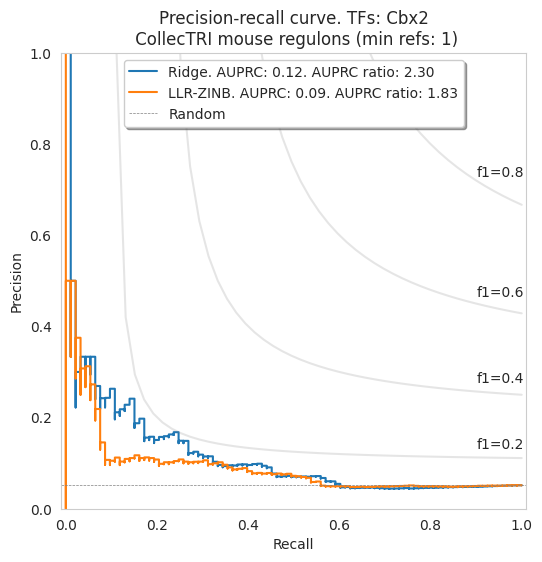

In [719]:
tfs = ['Cbx2']
threshold = 200
filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_dfs, filtered_mm10_stem_network_unique, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

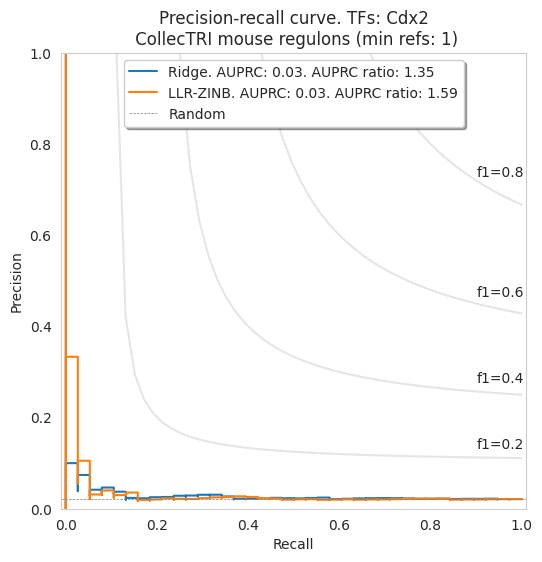

In [797]:
tfs = ['Cdx2']
threshold = 200
filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_dfs, filtered_mm10_stem_network_unique, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

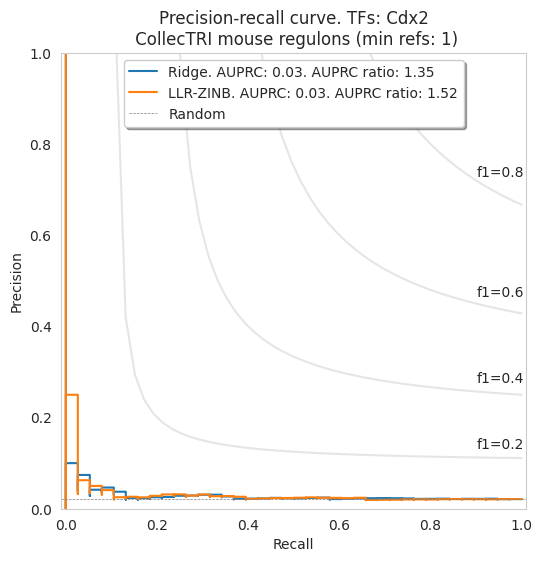

In [708]:
tfs = ['Cdx2']
threshold = 200
filtered_mm10_stem_network_unique = filtered_mm10_stem_network[filtered_mm10_stem_network['MACS2'] > threshold]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique[['source', 'target']]
filtered_mm10_stem_network_unique = filtered_mm10_stem_network_unique.drop_duplicates()
plot_precision_recall_curve(pred_dfs, filtered_mm10_stem_network_unique, tfs,
                            title=f'CollecTRI mouse regulons (min refs: {min_refs})')

In [ ]:
# filtered_mouse_regulons_ = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
plot_precision_recall_curve(true_coefs_df, filtered_mm10_stem_network_unique, tfs)
calculate_auprc(true_coefs_df, filtered_mm10_stem_network_unique, tfs)

/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in

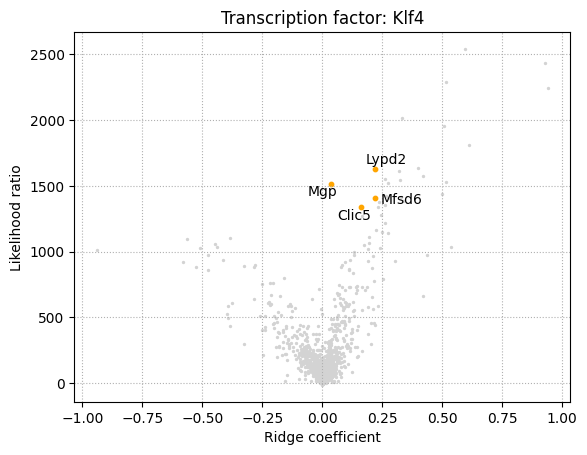

In [1043]:
tfs = ['Klf4']
plt.scatter(true_coefs_df[tfs], ll_df_2[tfs], s=2, c='lightgray')

m_1 = (true_coefs_df[tfs] > 0) & (true_coefs_df[tfs] < 0.225)
m_2 = ll_df_2[tfs] > 1300
m = (m_1 & m_2)
true_coefs_df[tfs][m.values], ll_df_2[tfs][m.values]
texts = []
for g in true_coefs_df[tfs][m.values].index:
    x = true_coefs_df[tfs].loc[g]
    y = ll_df_2[tfs].loc[g]
    texts.append(plt.text(x, y, g, size=10, ha='center', va='center'))
    # print(g, x, y)
    plt.scatter(x, y, s=10, c='orange')

adjust_text(texts)
plt.title(f'Transcription factor: {tfs[0]}')
plt.grid(linestyle='dotted')
plt.xlabel('Ridge coefficient')
plt.ylabel('Likelihood ratio');
plt.show()

/home/vinas/grn_inference/src/plot_utils.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_ = X_pred_[idxs_].ravel()


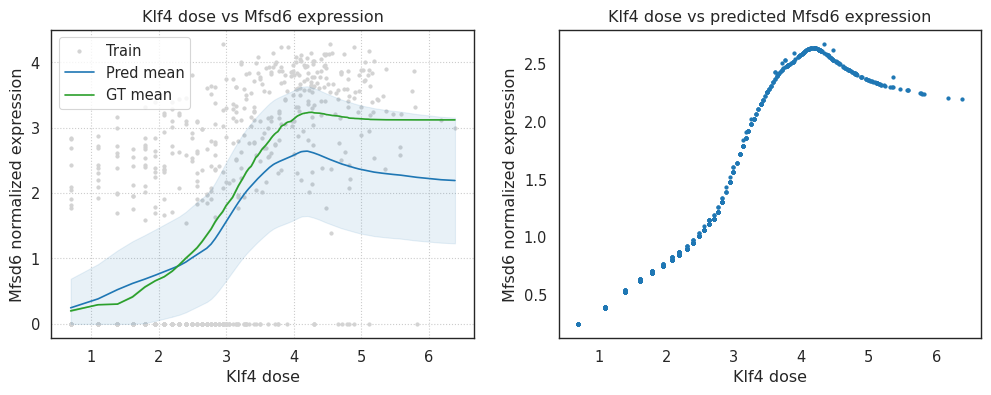

In [928]:
TF = 'Klf4'
TG = 'Mfsd6'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
plt.figure(figsize=(12, 4))
plot_expression_curve(TF, gene_idx, adata,
                      raw_counts=model.likelihood_fn == 'zinb',
                      mean_layer_key='mean_2', var_layer_key='var_2')

/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:756: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:757: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:897: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in

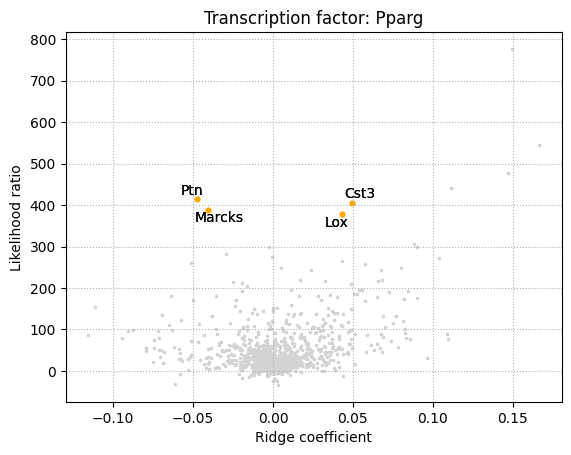

In [1042]:
tfs = ['Pparg']
plt.scatter(true_coefs_df[tfs], ll_df_2[tfs], s=2, c='lightgray')

m_1 = (true_coefs_df[tfs] > -0.05) & (true_coefs_df[tfs] < 0.05)
m_2 = ll_df_2[tfs] > 375
m = (m_1 & m_2)
true_coefs_df[tfs][m.values], ll_df_2[tfs][m.values]
texts = []
for g in true_coefs_df[tfs][m.values].index:
    x = true_coefs_df[tfs].loc[g]
    y = ll_df_2[tfs].loc[g]
    texts.append(plt.text(x, y, g, size=10, ha='center', va='center'))
    # print(g, x, y)
    plt.scatter(x, y, s=10, c='orange')

adjust_text(texts)
plt.title(f'Transcription factor: {tfs[0]}')
plt.grid(linestyle='dotted')
plt.xlabel('Ridge coefficient')
plt.ylabel('Likelihood ratio');
plt.show()

/home/vinas/grn_inference/src/plot_utils.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_ = X_pred_[idxs_].ravel()


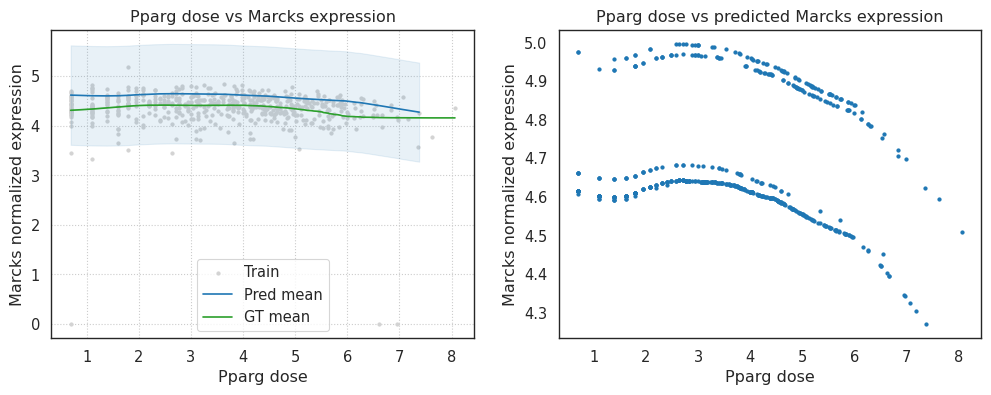

In [937]:
TF = 'Pparg'
TG = 'Marcks'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
plt.figure(figsize=(12, 4))
plot_expression_curve(TF, gene_idx, adata,
                      raw_counts=model.likelihood_fn == 'zinb',
                      mean_layer_key='mean_2', var_layer_key='var_2')

/tmp/ipykernel_3786934/736470276.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.scatter(adata_tf.obs['log_dose'].ravel(), adata_tf[:, m].X.ravel(), s=5)


,source,target,weight,PMID,n_refs,ones
330,Myc,Cxcr4,1,10229837;11145693,2,1
360,Myc,Cdkn1a,-1,10319992;10920185;11274368;12384701;12408820;1...,39,1
539,Myc,Actb,1,10375022;1901940;1906157,3,1
540,Myc,Brca1,1,10375022;11916966;11983916;12032322;12646176;1...,8,1
548,Myc,Bin1,1,10380878;18348166;21447800,3,1
...,...,...,...,...,...,...
35756,Myc,Bub1b,1,17297307,1,1
35760,Myc,Ezr,1,20010876,1,1
35762,Myc,Mad2l1,1,17297307,1,1
35763,Myc,Sgk1,1,20861224,1,1


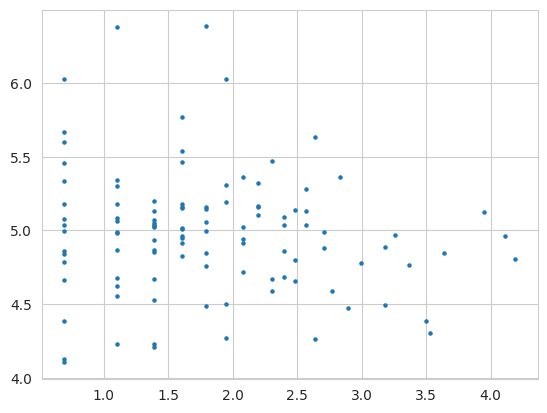

In [806]:
tf = 'Myc'
tg = 'mt-Rnr2' # 'Pcolce2' # 'Pcsk6' # 'Sox5' # 'Hk2' # 'Stmn1' # 'Ccdc163' # 'Tmem38b' # 'Ass1'  # 'Plxdc2' # 'Akap12'
adata_tf = adata[adata.obs['TF'] == tf]
m = adata_tf.var['Symbol'] == tg
plt.scatter(adata_tf.obs['log_dose'].ravel(), adata_tf[:, m].X.ravel(), s=5)
filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]

/home/vinas/grn_inference/src/plot_utils.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = dose[idxs]
/home/vinas/grn_inference/src/plot_utils.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = dose[idxs]


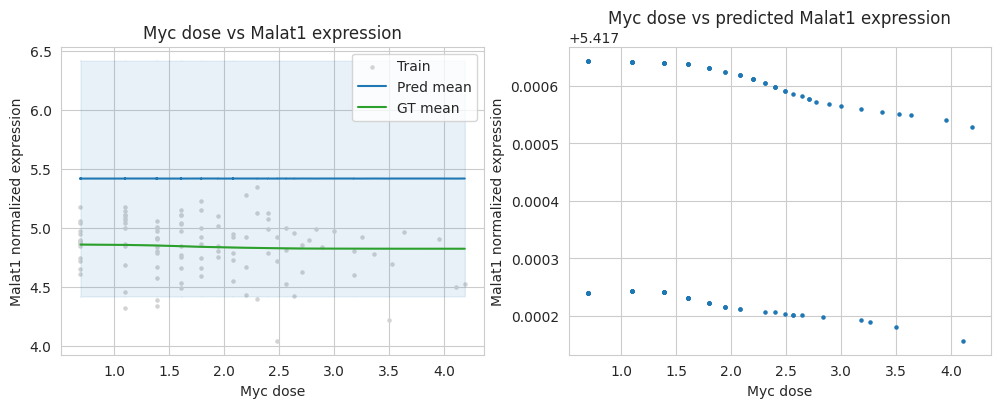

In [752]:
TF = 'Myc'
TG = 'Malat1'
gene_idx = np.where(adata.var['Symbol'] == TG)[0][0]
plt.figure(figsize=(12, 4))
plot_expression_curve(TF, gene_idx, adata,
                      raw_counts=model.likelihood_fn == 'zinb',
                      mean_layer_key='null_mean', var_layer_key='null_var')

#### Base GRN

AttributeError: module 'matplotlib' has no attribute 'backend_bases'

In [ ]:
# Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

# Check data
base_GRN.head()

#### Explore ground-truth correlations

/tmp/ipykernel_3786934/2808960134.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.scatter(adata_tf.obs['log_dose'].ravel(), adata_tf[:, m].X.ravel(), s=5)


,source,target,weight,PMID,n_refs
1508,Klf4,Cdkn1a,1,10749849;18483411;18645021;19737957;21132436;2...,11
2006,Klf4,Actg2,-1,10954723;16858008,2
4280,Klf4,Id3,-1,12087069;19618124,2
4284,Klf4,Klf4,1,12087155;22337869;22854048,3
4649,Klf4,Odc1,-1,12297499;15570219,2
5881,Klf4,Iapp,1,12919939;14675715,2
6406,Klf4,Hdc,-1,14670968;17827213,2
10572,Klf4,Acta2,1,16858008;18511453;22241174;23646205,4
10751,Klf4,Slc5a6,1,16959947;17135299,2
15988,Klf4,Notch1,1,19717984;20442780,2


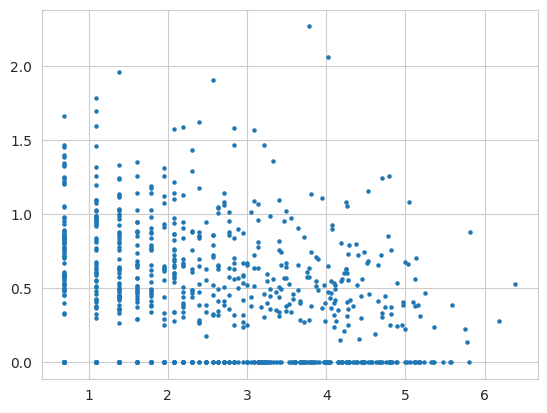

In [208]:
tf = 'Klf4'
tg = 'Lars2' # 'Pcolce2' # 'Pcsk6' # 'Sox5' # 'Hk2' # 'Stmn1' # 'Ccdc163' # 'Tmem38b' # 'Ass1'  # 'Plxdc2' # 'Akap12'
adata_tf = adata[adata.obs['TF'] == tf]
m = adata_tf.var['Symbol'] == tg
plt.scatter(adata_tf.obs['log_dose'].ravel(), adata_tf[:, m].X.ravel(), s=5)
filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]

In [225]:
# Store GT and preds in matrix
tfs = filtered_mm10_stem_network_unique['source'].unique()
ctgs = filtered_mm10_stem_network_unique['target'].unique()

filtered_mm10_stem_network_unique['ones'] = 1

df = ridge_perm_df[tfs].loc[ctgs]
gt_df = filtered_mm10_stem_network_unique[['source', 'target', 'ones']].pivot(index='target', columns='source', values='ones')  # values='MACS2'
gt_df = gt_df.loc[df.index]
gt_df = gt_df.fillna(0)

Text(0.5, 0, 'P-value')

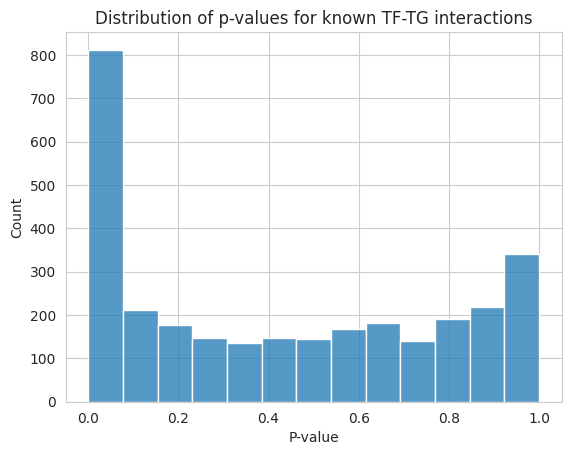

In [114]:
v = np.diag(df[filtered_mm10_stem_network_unique['source']].loc[filtered_mm10_stem_network_unique['target']].values)
sns.histplot(v)
plt.title('Distribution of p-values for known TF-TG interactions')
plt.xlabel('P-value')

Text(0.5, 0, 'P-value')

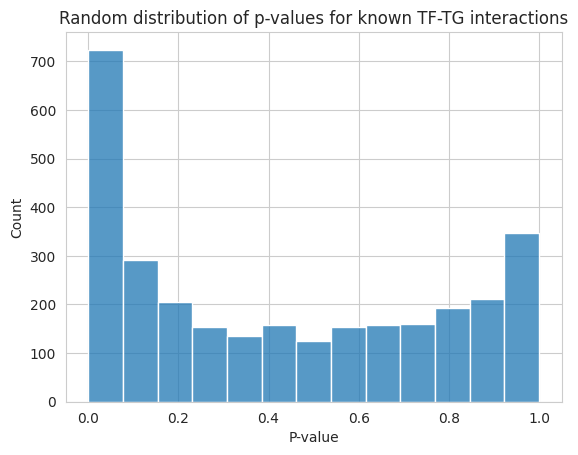

In [115]:
random_df = df.copy()
random_df.index = np.random.permutation(df.index)
random_df.columns = np.random.permutation(df.columns)
v = np.diag(random_df[filtered_mm10_stem_network_unique['source']].loc[filtered_mm10_stem_network_unique['target']].values)
sns.histplot(v)
plt.title('Random distribution of p-values for known TF-TG interactions')
plt.xlabel('P-value')

Text(0.5, 0, 'P-value')

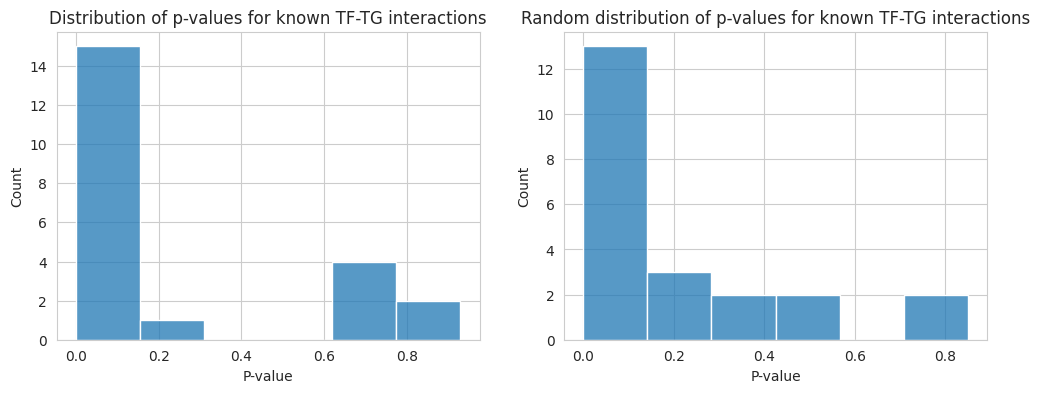

In [161]:
tf = 'Klf4'
tgs = filtered_mm10_stem_network_unique[filtered_mm10_stem_network_unique['source'] == tf]['target'].values
v = df[tf].loc[tgs].values
v_random = df[tf].sample(n=len(tgs))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Distribution of p-values for known TF-TG interactions')
sns.histplot(v)
plt.xlabel('P-value')

plt.subplot(1, 2, 2)
plt.title('Random distribution of p-values for known TF-TG interactions')
sns.histplot(v_random)
plt.xlabel('P-value')

In [126]:
true_aps = []
random_aps = []
tfs = filtered_mm10_stem_network_unique['source'].unique()
for tf in tfs:
    y_true = 1-gt_df[tf].abs().values.ravel()
    y_scores = df[tf].values.ravel()
    y_scores_random = random_df[tf].values.ravel()
    y_scores_random_2 = np.random.permutation(random_df[tf].values.ravel())
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    true_aps.append(average_precision_score(y_true, y_scores))
    random_aps.append(average_precision_score(y_true, y_scores_random_2))

In [127]:
np.log2(np.array(true_aps) / np.array(random_aps))

array([-0.02993223, -0.01869691, -0.00199405, -0.00867276, -0.0348295 ,
       -0.01300909, -0.0515828 ,  0.00284873, -0.00447549, -0.00303348,
       -0.00394744, -0.00355248,  0.004104  , -0.00379731, -0.01448373,
       -0.00292488,  0.01391244, -0.00273147, -0.00098942,  0.00519312,
       -0.00053027, -0.00022021,  0.00456488,  0.00426807,  0.00198087,
        0.00451217, -0.01000418, -0.00525662, -0.00048068, -0.00275097,
       -0.00620484,  0.00449928, -0.00042861,  0.0039738 ,  0.01136745,
        0.00084291,  0.00108895, -0.00020044, -0.00181445])

AUPRC 0.08720349678442602 AUPRC ratio 1.4578665547357859


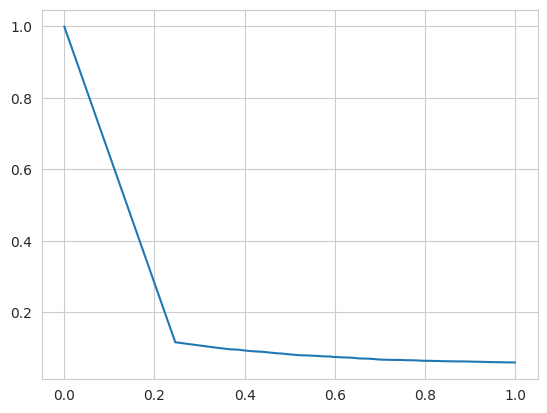

In [244]:
y_true = gt_df.abs().values.ravel()
y_scores = 1-df.values.ravel()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.plot(recall, precision)
auprc = average_precision_score(y_true, y_scores)
print('AUPRC', auprc, 'AUPRC ratio', auprc/y_true.mean())

0.056965518838987705

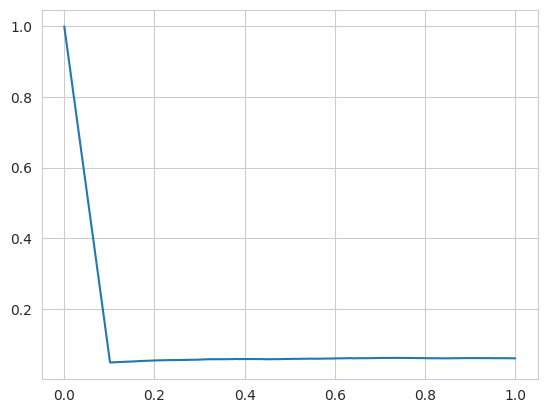

In [199]:
tfs = filtered_mm10_stem_network_unique['source'].unique()
ctgs = filtered_mm10_stem_network_unique['target'].unique()
random_df = ridge_perm_df[np.random.permutation(tfs)].loc[np.random.permutation(ctgs)]
# gt_df = filtered_mouse_regulons.pivot(index='target', columns='source', values='weight')
# gt_df = gt_df.fillna(0)
y_true = gt_df.abs().values.ravel()
y_scores = 1-random_df.values.ravel()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
plt.plot(recall, precision)
auprc_random = average_precision_score(y_true, y_scores)
auprc_random

/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


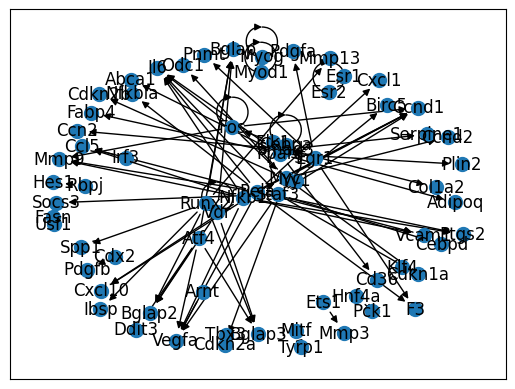

In [160]:
G = nx.DiGraph()
G.add_edges_from(filtered_mouse_regulons[['source', 'target']].values)
pos =  nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 100)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True);

/tmp/ipykernel_2739737/1271545510.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  plt.scatter(adata_tf.obs['log_dose'].ravel(), adata_tf[:, m].X.ravel(), s=5)


,source,target,weight,PMID,n_refs
777,Nfkb1,Ccnd1,1,10409765;10464245;11861406;12894581;15756023;1...,20
1014,Nfkb1,Vcam1,1,10329958;10496926;10553096;10833420;10946302;1...,17
2048,Nfkb1,Il6,1,10329846;10469356;10569191;10823821;10903137;1...,71
2243,Nfkb1,Mmp9,1,10359016;11060311;11376631;12105194;12193473;1...,37
2273,Nfkb1,Ptgs2,1,10827178;11082190;12067569;12349897;12466023;1...,33
5622,Nfkb1,Myc,1,11114727;12504005;12783888;12894581;1515224;17...,16
16758,Nfkb1,Cxcl10,1,10756005;16253303;16818736;16982926;17274000;1...,12
29224,Nfkb1,Ccl5,1,11259372;11389171;11413310;11478739;11700023;1...,17
29397,Nfkb1,Vegfa,1,12160329;15517885;15856023;16684540;17407600;1...,10


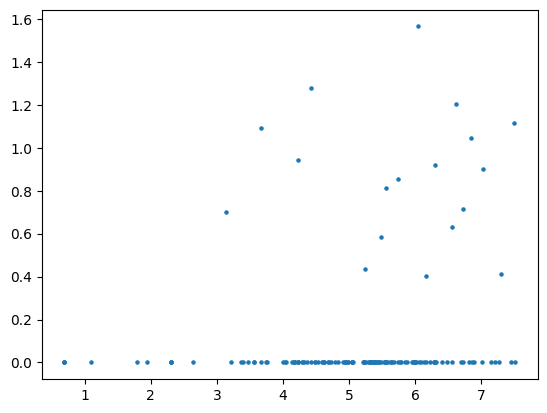

In [161]:
tf = 'Nfkb1'
tg = 'Ptgs2'
adata_tf = adata[adata.obs['TF'] == tf]
m = adata_tf.var['Symbol'] == tg
plt.scatter(adata_tf.obs['log_dose'].ravel(), adata_tf[:, m].X.ravel(), s=5)
tgs_df = filtered_mouse_regulons[filtered_mouse_regulons['source'] == tf]
tgs_df

In [162]:
# Store GT and preds in matrix
tfs = filtered_mouse_regulons['source'].unique()
ctgs = filtered_mouse_regulons['target'].unique()
df = ridge_perm_df[tfs].loc[ctgs]
gt_df = filtered_mouse_regulons.pivot(index='target', columns='source', values='weight')
gt_df = gt_df.loc[df.index]
gt_df = gt_df.fillna(0)

/home/vinas/miniconda3/envs/grn/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


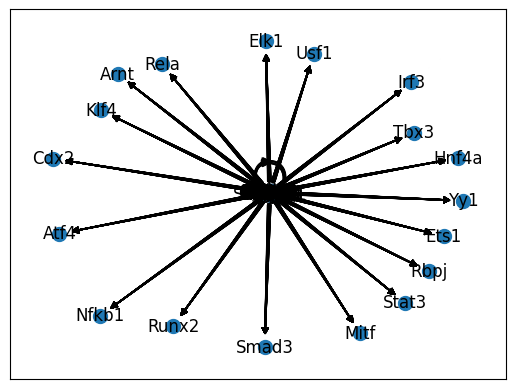

In [163]:
cutoff = 0.05
pred_edges = (df < cutoff).stack().index.tolist()
G = nx.DiGraph()
G.add_edges_from(pred_edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 100)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True);

In [164]:
random_df = df.copy()
random_df.index = np.random.permutation(df.index)
random_df.columns = np.random.permutation(df.columns)

Text(0.5, 0, 'P-value')

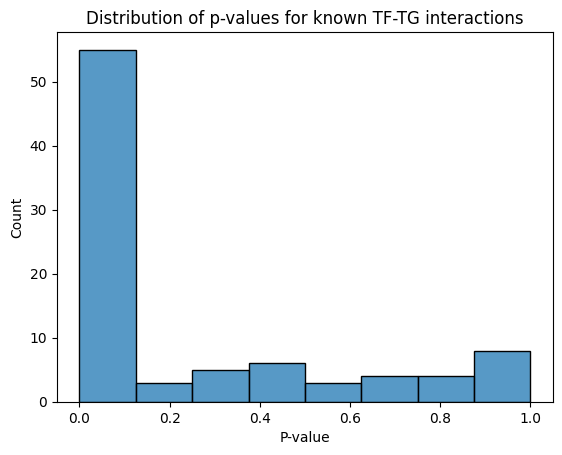

In [165]:
v = np.diag(df[filtered_mouse_regulons['source']].loc[filtered_mouse_regulons['target']].values)
sns.histplot(v)
plt.title('Distribution of p-values for known TF-TG interactions')
plt.xlabel('P-value')

Text(0.5, 0, 'P-value')

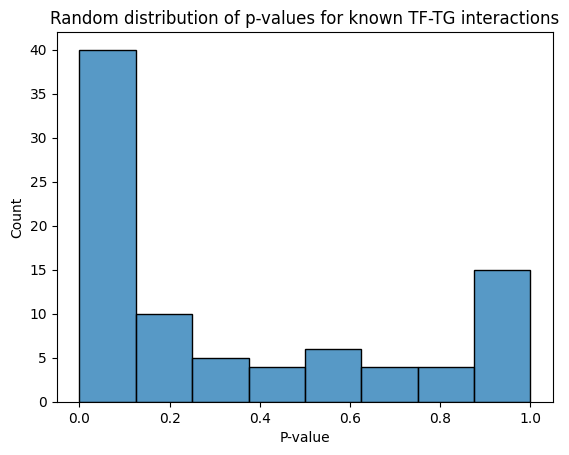

In [192]:
v = np.diag(random_df[filtered_mouse_regulons['source']].loc[filtered_mouse_regulons['target']].values)
sns.histplot(v)
plt.title('Random distribution of p-values for known TF-TG interactions')
plt.xlabel('P-value')

In [186]:
tf = 'Esr2' # 'Nfkb1'
true_aps = []
random_aps = []
for tf in tfs:
    y_true = 1-gt_df[tf].abs().values.ravel()
    y_scores = df[tf].values.ravel()
    y_scores_random = random_df[tf].values.ravel()
    y_scores_random_2 = np.random.permutation(random_df[tf].values.ravel())
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    true_aps.append(average_precision_score(y_true, y_scores))
    random_aps.append(average_precision_score(y_true, y_scores_random_2))

In [191]:
np.log2(np.array(true_aps) / np.array(random_aps))

array([ 2.61532395e-02,  4.88441243e-03, -1.66253921e-02,  1.72730167e-01,
       -4.33349663e-02,  4.23248142e-02, -6.25045381e-02,  1.15579463e-01,
       -4.10362786e-02, -1.72576656e-02,  1.02957284e-01,  4.01449426e-02,
        9.42090567e-02,  8.93404387e-02,  9.50135545e-02, -3.87424408e-02,
       -2.16640909e-02,  2.21532498e-02,  3.20342650e-16,  1.83647918e-02,
        8.83497495e-02,  8.31263950e-04, -2.53431112e-02, -9.79026082e-03,
       -8.50746265e-04,  7.34880732e-03,  3.68479046e-02])

In [187]:
(np.array(true_aps) - np.array(random_aps)).mean()

0.015619804831696884

<Axes: ylabel='Count'>

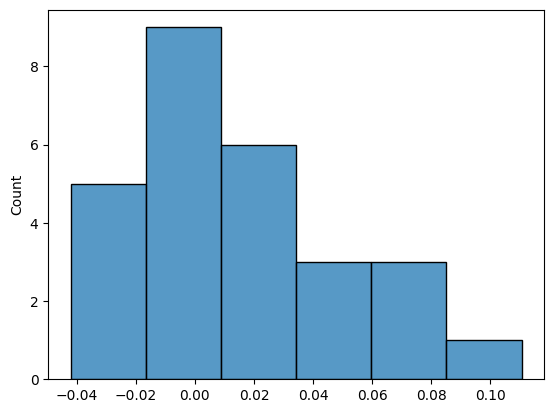

In [188]:
sns.histplot(np.array(true_aps) - np.array(random_aps))

In [103]:
y_true = 1-gt_df.abs().values.ravel()
y_scores = df.values.ravel()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
average_precision_score(y_true, y_scores)

0.934994071845814

In [104]:
y_true = 1-gt_df.abs().values.ravel()
y_scores = random_df.values.ravel()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
average_precision_score(y_true, y_scores)

0.934994071845814

In [101]:
tfs = filtered_mouse_regulons['source'].unique()
ctgs = filtered_mouse_regulons['target'].unique()
df = ridge_perm_df[np.random.permutation(tfs)].loc[np.random.permutation(ctgs)]
# gt_df = filtered_mouse_regulons.pivot(index='target', columns='source', values='weight')
# gt_df = gt_df.fillna(0)
y_true = 1-gt_df.abs().values.ravel()
y_scores = df.values.ravel()
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
average_precision_score(y_true, y_scores)

0.9325149323733668